<a href="https://colab.research.google.com/github/Neil-Cardoz/Deep-Learning/blob/main/Simple_LSTM_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification of E-Commerce Product Descriptions Using LSTM

# Objectives

* To clean and preprocess raw product description text for machine learning.

* To convert the cleaned text into numerical representations suitable for deep learning models.

* To build an LSTM-based neural network capable of classifying product descriptions into categories such as Books, Clothing & Accessories, Electronics, and Household.

* To evaluate the model performance using classification metrics such as accuracy, precision, recall, and F1-score.

# How LSTM Works ?

## 1. Text Preprocessing

* Removal of HTML tags, punctuation, numbers, emojis, and stopwords to reduce noise.

* Lower casing, lemmatization, and handling abbreviations/contractions to standardize words.

* Tokenization and padding sequences to ensure uniform input lengths for the model.

## 2. Word Representation

* Tokenization converts text into integer sequences.

* Embedding Layer transforms words into dense vectors (embeddings) capturing semantic meaning.

## 3. LSTM Networks

* LSTM (Long Short-Term Memory) is a type of Recurrent Neural Network designed to handle sequential data.

* It uses “gates” to control the flow of information, making it effective at learning long-term dependencies.

* Particularly useful for Natural Language Processing tasks such as classification, sentiment analysis, and translation.

## 4. Model Architecture

* Embedding layer to represent words in a dense, low-dimensional space.

* LSTM layer with dropout to handle sequential dependencies and avoid overfitting.

* Dense softmax output layer to classify into multiple categories.

## 5. Evaluation Metrics

* Accuracy : The proportion of correct predictions.

* Precision/Recall/F1-Score : Provide deeper insight into class-wise performance.

* Confusion Matrix : Visual representation of predictions versus true labels.

In [1]:
!pip install contractions -qq


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 12.3 MB/s eta 0:00:00


In [2]:
# NLP
import string, re, nltk
from string import punctuation
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
import spacy
import contractions

nltk.download("all")
!python -m spacy download en_core_web_sm


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 81.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [5]:
!wget https://zenodo.org/records/3355823/files/ecommerceDataset.csv

data = pd.read_csv('ecommerceDataset.csv', names=['Labels','Description'])
data.head()


--2025-09-29 12:03:24--  https://zenodo.org/records/3355823/files/ecommerceDataset.csv
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.43.25, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36949114 (35M) [text/plain]
Saving to: ‘ecommerceDataset.csv’

ecommerceDataset.cs 100%[===================>]  35.24M  1.07MB/s    in 29s     

2025-09-29 12:03:55 (1.21 MB/s) - ‘ecommerceDataset.csv’ saved [36949114/36949114]



,Labels,Description
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...


In [6]:
len(data)

data.dropna(inplace=True)
data.drop_duplicates(inplace=True)
data.reset_index(drop=True, inplace=True)

len(data)


27802

In [7]:
regexp = RegexpTokenizer("[\w']+")

# Lowercase
def text_lower(text):
    text = text.lower()
    return text

# Remove Whitespace
def remove_whitespace(text):
    text = text.strip()
    return text

# Remove Punctuation
def remove_punctuation(text):
    punct = string.punctuation
    punct = punct.replace("", "")
    text = text.translate(str.maketrans("", "", punct))
    return text

# Remove HTML
def remove_html(text):
    html = re.compile(r'<.*?>')
    text = html.sub(r'', text)
    return text

# Removing emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    return text

# Remove URLs
def remove_http_links(text):
    text = re.sub('http://\S+|https://\S+', '', text)
    return text


<>:1: SyntaxWarning: invalid escape sequence '\w'
<>:41: SyntaxWarning: invalid escape sequence '\S'
<>:1: SyntaxWarning: invalid escape sequence '\w'
<>:41: SyntaxWarning: invalid escape sequence '\S'
/tmp/ipython-input-2205047382.py:1: SyntaxWarning: invalid escape sequence '\w'
  regexp = RegexpTokenizer("[\w']+")
/tmp/ipython-input-2205047382.py:41: SyntaxWarning: invalid escape sequence '\S'
  text = re.sub('http://\S+|https://\S+', '', text)


In [9]:
# Convert Abbreviated Words
abbrev = pd.read_csv('/content/abbrevations.csv', names=['SMF','FF'])

abbrev_lower = pd.DataFrame()
abbrev_lower['SMF'] = abbrev['SMF'].apply(str.lower)
abbrev_lower['FF'] = abbrev['FF'].apply(str.lower)
abbrev_dict = dict(zip(list(abbrev_lower.SMF), list(abbrev_lower.FF)))
abbrev_words = list(abbrev_dict.keys())

def convert_abbrev(text):
    words = []
    for word in regexp.tokenize(text):
        if word in abbrev_words:
            words = words + abbrev_dict[word].split()
        else:
            words = words + word.split()
    text_converted = " ".join(words)
    return text_converted

# Convert Contractions like you're
def convert_contractions(text):
    text = contractions.fix(text)
    return text

# Remove Stopwords
def remove_stopwords(text):
    text = " ".join([word for word in nltk.tokenize.word_tokenize(text)
                    if word not in stopwords.words('english')])
    return text

# Lemmatization
nlp = spacy.load("en_core_web_sm", disable=['parser','ner'])
def lemmatize(text):
    text = " ".join([token.lemma_ for token in nlp(text)])
    return text

# Remove Non Alphabetic Characters
def discard_non_alpha(text):
    word_list_non_alpha = [word for word in regexp.tokenize(text)
                           if word.isalpha()]
    text = " ".join(word_list_non_alpha)
    return text

# Aggregating All definitions
def text_clean(text):
    text = text_lower(text)
    text = remove_whitespace(text)
    text = remove_http_links(text)
    text = remove_html(text)
    text = remove_emoji(text)
    text = convert_abbrev(text)
    text = convert_contractions(text)
    text = remove_stopwords(text)
    text = discard_non_alpha(text)
    text = lemmatize(text)
    return text

# Apply on Dataset
data['Description_Clean'] = data['Description'].apply(text_clean)
data.head()


,Labels,Description,Description_Clean
0,Household,Paper Plane Design Framed Wall Hanging Motivat...,paper plane design frame wall hang motivationa...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",saf frame paint wood inch x inch special effec...
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...,saf texture modern art print frame paint synth...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1...",saf flower print frame paint synthetic inch x ...
4,Household,Incredible Gifts India Wooden Happy Birthday U...,incredible gift india wooden happy birthday un...


In [10]:
le = LabelEncoder()
data['Encoded_Labels'] = le.fit_transform(data['Labels'])
label_len = len(le.classes_)
inv_labels = le.inverse_transform([i for i in range(label_len)])
data.head()


,Labels,Description,Description_Clean,Encoded_Labels
0,Household,Paper Plane Design Framed Wall Hanging Motivat...,paper plane design frame wall hang motivationa...,3
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",saf frame paint wood inch x inch special effec...,3
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...,saf texture modern art print frame paint synth...,3
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1...",saf flower print frame paint synthetic inch x ...,3
4,Household,Incredible Gifts India Wooden Happy Birthday U...,incredible gift india wooden happy birthday un...,3


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    data.Description_Clean,
    data.Encoded_Labels,
    stratify=data.Encoded_Labels,
    random_state=2)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)


In [12]:
batch_size = 64
max_words = 10000
max_len = 200
embedding_dim = 100
lstm_units = 64

tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
seqs = tok.texts_to_sequences(X_train)
test_seqs = tok.texts_to_sequences(X_test)
seq_matrix = pad_sequences(seqs, maxlen=max_len)
test_seq_matrix = pad_sequences(test_seqs, maxlen=max_len)

seq_matrix[0]


array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0, 2857, 5137, 1052,  533,
       2773, 1052,   42,   13,  237,   20,  723,   

In [13]:
def LSTM_Model(words, len, dim, units, num_labels):
    model = tf.keras.Sequential()
    model.add(Embedding(input_dim=words, output_dim=dim, input_length=len))
    model.add(LSTM(units=units, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(num_labels, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = LSTM_Model(max_words, max_len, embedding_dim, lstm_units, label_len)
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.fit(seq_matrix,
          y_train,
          epochs=3,
          batch_size=batch_size,
          validation_split=0.2)


Epoch 1/3
261/261 ━━━━━━━━━━━━━━━━━━━━ 172s 628ms/step - accuracy: 0.6728 - loss: 0.8478 - val_accuracy: 0.9367 - val_loss: 0.2684
Epoch 2/3
261/261 ━━━━━━━━━━━━━━━━━━━━ 164s 626ms/step - accuracy: 0.9432 - loss: 0.2246 - val_accuracy: 0.9429 - val_loss: 0.2231
Epoch 3/3
261/261 ━━━━━━━━━━━━━━━━━━━━ 163s 625ms/step - accuracy: 0.9664 - loss: 0.1443 - val_accuracy: 0.9456 - val_loss: 0.2291


218/218 ━━━━━━━━━━━━━━━━━━━━ 25s 114ms/step
                        precision    recall  f1-score   support

                 Books       0.95      0.94      0.94      1564
Clothing & Accessories       0.96      0.97      0.96      1419
           Electronics       0.93      0.92      0.93      1327
             Household       0.94      0.95      0.95      2641

              accuracy                           0.94      6951
             macro avg       0.94      0.94      0.94      6951
          weighted avg       0.94      0.94      0.94      6951



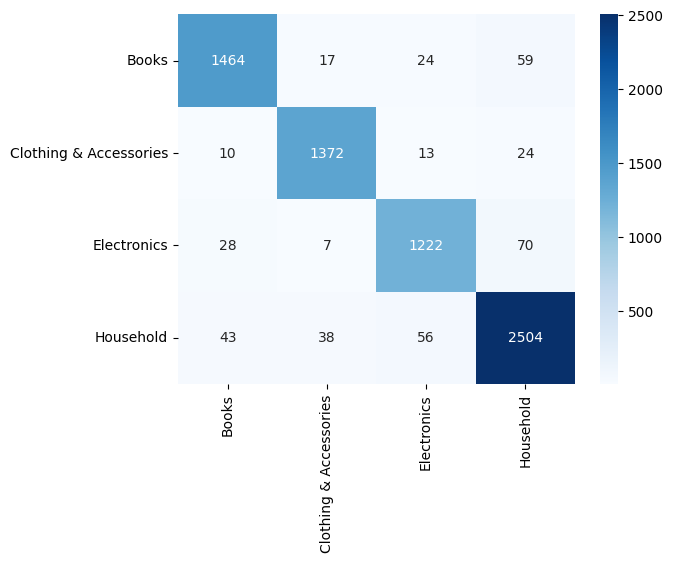

In [15]:
prediction = model.predict(test_seq_matrix)

from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, np.argmax(prediction, axis=1),
                            target_names=inv_labels))

sns.heatmap(confusion_matrix(y_test, np.argmax(prediction, axis=1)),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=inv_labels,
            yticklabels=inv_labels)
plt.show()


# Conclusion

The LSTM-based model achieved an overall accuracy of 94% across 6,951 samples, indicating strong predictive performance.

## Class-wise performance :

* **Books** : Precision 0.95, Recall 0.94, F1 score 0.94

* **Clothing & Accessories** : Precision 0.96, Recall 0.97, F1 score 0.96

* **Electronics** : Precision 0.93, Recall 0.92, F1 score 0.93

* **Household** : Precision 0.94, Recall 0.95, F1 score 0.95

* These metrics show the model performed consistently well across all product categories with balanced precision and recall .

* The highest performance was observed for the “Clothing & Accessories” category (F1-score 0.96), while “Electronics” showed slightly lower but still strong performance.

* This confirms that the text preprocessing pipeline (removing noise, lemmatizing, handling abbreviations) and LSTM architecture effectively captured the context and semantics of product descriptions.

* Overall, the model demonstrates the suitability of LSTM networks for real-world text classification tasks, especially when dealing with varied and noisy e-commerce product descriptions.